In [ ]:
#required packages
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
from pymc3 import Model
import pymc3 as pm
import theano
import theano.tensor as tt
import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.preprocessing import StandardScaler

In [ ]:
# Load dataset
df = pd.read_csv('denver_prop_listing_clean.csv')

#convert to datetime format
df["list_date"] = pd.to_datetime(df["list_date"])
df["sale_date"] = pd.to_datetime(df["sale_date"])

In [ ]:
mapping = {k: v for v, k in enumerate(df.property_type.unique())}
mapping

{'SINGLE': 0,
 'CONDO': 1,
 'OTHER': 2,
 'MULTI_FAMILY': 3,
 'TOWNHOUSE': 4,
 'LAND': 5}

In [ ]:
df['property_type_code'] = df['property_type'].map(mapping)
df.head()

,property_id,zipcode,fips,latitude,longitude,sqft,property_type,has_central_air,has_jacuzzi,has_pool,has_solar,has_garage,list_date,sale_date,sale_price,bedrooms,full_baths,ct_key,sale_price_per_sqft,property_type_code
0,138574001,80002,8059.0,39.79270,-105.13026,3047.0,SINGLE,True,False,True,False,True,2020-09-24,2020-11-02,630000.0,5.0,3.0,8.059010e+09,206.760748,0
1,138573806,80002,8059.0,39.79424,-105.12171,4382.0,SINGLE,True,False,False,False,True,2020-09-24,2020-10-29,805000.0,4.0,2.0,8.059010e+09,183.706070,0
2,138572945,80002,8059.0,39.79565,-105.11674,2654.0,SINGLE,False,False,False,False,True,2020-09-24,2020-10-19,665000.0,4.0,2.0,8.059010e+09,250.565185,0
3,138568013,80002,8059.0,39.79655,-105.09923,2265.0,SINGLE,False,False,False,False,False,2020-09-24,2020-10-28,607000.0,4.0,2.0,8.059010e+09,267.991170,0
4,138564524,80002,8059.0,39.79399,-105.06972,1431.0,SINGLE,False,False,False,False,False,2020-09-24,2020-10-16,425000.0,4.0,1.0,8.059010e+09,296.995108,0


In [ ]:
# Sale           331537
# Withdrawn       48375
# Active          33218
# Expired         22163
# Pending         15960
# Other             711
# Foreclosure       316
# For Rent          123
# Pending,           95
# Cancelled          86
# LOT                70
# Coming Soon         6

Current approach is trained on a particular discretized timeframe (say a quarter / 3 months). One potential exploration is to train the heirarchical models on separate discretized quarters and generate a time series on the changing sub-market classifications across the quarters. However, one concern is when a house is sold before a particular quarter and the model would assume that its corresponding sub-market has low supply?

In [ ]:
def gen_y(t_disc, data, t0=None):
    ''' 
    t_disc: datetime.timedelta(days = XX)
    t0: datetime.datetime(YYYY,MM,DD)
    '''

    if t0 is not None:
        listed = np.array(((data['list_date'] >= t0) & (data['list_date'] < t0 + t_disc)) | ((data['list_date'] < t0) & (data['sale_date'] >= t0)), dtype=np.int8)
        sale = np.array((data['sale_date'] >= t0) & (data['sale_date'] < t0 + t_disc), dtype = np.int8)
        return np.vstack((listed, sale)).T
    #else:
        #TODO


In [ ]:
y_2019Q2 = gen_y(datetime.timedelta(days = 90), df, datetime.datetime(2019,4,1))

In [ ]:
# Remove all rows that aren't listed in that period
listed_index = np.where(y_2019Q2[:,0] == 1)
df_2019Q2 = df.iloc[listed_index]

In [ ]:
# Build X matrix and Y target vector

# X = df.drop(columns=['property_id', 'zipcode', 'list_date', 'sale_date', 'current_status', 'property_type', 'has_jacuzzi', 'has_garage'])
X = df_2019Q2.drop(columns=['property_id', 'zipcode', 'list_date', 'sale_date', 'property_type', 'has_jacuzzi', 'has_garage', 'sale_price', 'ct_key', 'sale_price_per_sqft'])
X = X.reset_index(drop=True)
columns_to_scale = ['fips', 'latitude', 'longitude', 'sqft',
                    'full_baths']
scaler = StandardScaler()
X[columns_to_scale] =  scaler.fit_transform(X[columns_to_scale])

Y = y_2019Q2[np.where(y_2019Q2[:,0]==1)]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7567 entries, 0 to 7566
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fips                7567 non-null   float64
 1   latitude            7567 non-null   float64
 2   longitude           7567 non-null   float64
 3   sqft                7567 non-null   float64
 4   has_central_air     7567 non-null   bool   
 5   has_pool            7567 non-null   bool   
 6   has_solar           7567 non-null   bool   
 7   bedrooms            7567 non-null   float64
 8   full_baths          7567 non-null   float64
 9   property_type_code  7567 non-null   int64  
dtypes: bool(3), float64(6), int64(1)
memory usage: 436.1 KB


(7567, 10)

In [ ]:
# Split into training and testing datasets
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)

In [ ]:
K = 5 # Number of submarkets
n_homes, n_features = X.shape
mu_k_prior_var = 10
sigma_k_prior_var = 10
mu_b1_prior_var = 1
sigma_b1_prior_var = 1
mu_b2_prior_var = 1
sigma_b2_prior_var = 1

with Model() as baseline_mod:

    # Submarket latent variable
    p = pm.Dirichlet("p", a=np.ones(K)/K, shape=K)

    submarket = pm.Categorical('submarket', p=p, shape=n_homes)

    # Generate homes features 
    mu_k = pm.Normal('mu_k', mu=0, sigma=mu_k_prior_var, shape=(K,n_features))

    sigma_k = pm.Normal('sigma_k', mu=0, sigma=sigma_k_prior_var, shape=(n_features,n_features))

    homes = pm.MvNormal('homes', mu_k[submarket,:], sigma_k, observed=X)

    # Generate betas for "hedonic" regression
    mu_b1 = pm.Normal('mu_b1', mu=0, sigma=mu_b1_prior_var, shape=(K,n_features))

    sigma_b1 = pm.Normal('sigma_b1', mu=0, sigma=sigma_b1_prior_var, shape=(n_features,n_features))

    beta1 = pm.MvNormal('beta1', mu_b1[submarket,:], sigma_b1, shape=(n_homes,n_features))

    mu_b2 = pm.Normal('mu_b2', mu=0, sigma=mu_b2_prior_var, shape=(K,n_features))

    sigma_b2 = pm.Normal('sigma_b2', mu=0, sigma=sigma_b2_prior_var, shape=(n_features,n_features))

    beta2 = pm.MvNormal('beta2', mu_b2[submarket,:], sigma_b2, shape=(n_homes,n_features))

    # Final layer
    y1 = pm.Bernoulli('y1', p=1/(1+tt.exp(-tt.tensordot(homes,tt.transpose(beta1)))), observed = Y[:,0])
    y2 = pm.Bernoulli('y2', p=1/(1+tt.exp(-tt.tensordot(homes,tt.transpose(beta1)))), observed = Y[:,1])



    # y1 = pm.Normal('y1', mu=tt.dot(tt.matrix(homes),tt.transpose(tt.matrix(beta1)))[0,:], sigma=sigma_y1, shape=n_homes)
    # y1 = pm.Normal('y1', mu=1/(1+tt.exp(tt.tensordot(homes,tt.transpose(beta1)))), sigma=sigma_y1, observed = y_2019Q2[:,0])
    # y2 = pm.Normal('y2', mu=1/(1+tt.exp(tt.tensordot(homes,tt.transpose(beta2)))), sigma=sigma_y2, observed = y_2019Q2[:,1])
    
    # Deterministic cannot have observed argument
    # pred1 = pm.Deterministic('pred1', 1/(1+np.exp(-y1)), observed = y_2019Q2[:,0])
    # pred2 = pm.Deterministic('pred1', 1/(1+np.exp(-y2)), observed = y_2019Q2[:,1])

In [ ]:
# theano.config.exception_verbosity='high'

with baseline_mod:

    step1 = pm.Metropolis(vars=[p, mu_k, sigma_k, homes, mu_b1, sigma_b1, beta1, mu_b2, sigma_b2, beta2, y1, y2])
    step2 = pm.ElemwiseCategorical(vars=[submarket], values=np.arange(K))
    tr = pm.sample(1000, step = [step1, step2], start = {"sigma_k": np.eye(n_features), "sigma_b1": np.eye(n_features), "sigma_b2": np.eye(n_features)}, compute_convergence_checks=False)

<ipython-input-63-8e6bedc54b6b>:6: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step2 = pm.ElemwiseCategorical(vars=[submarket], values=np.arange(K))
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [beta2]
>>Metropolis: [sigma_b2]
>>Metropolis: [mu_b2]
>>Metropolis: [beta1]
>>Metropolis: [sigma_b1]
>>Metropolis: [mu_b1]
>>Metropolis: [sigma_k]
>>Metropolis: [mu_k]
>>Metropolis: [p]
>ElemwiseCategorical: [submarket]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 349 seconds.


In [ ]:
values = []
counts = []

for i in range(20):
    value, count = np.unique(tr['submarket'][i+1000], return_counts = True)
    values.append(value)
    counts.append(count)

In [ ]:
values

[array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3]),
 array([1, 2, 3])]

In [ ]:
counts

[array([ 123, 7398,   46]),
 array([ 124, 7399,   44]),
 array([ 124, 7398,   45]),
 array([ 124, 7398,   45]),
 array([ 124, 7400,   43]),
 array([ 124, 7399,   44]),
 array([ 124, 7397,   46]),
 array([ 124, 7398,   45]),
 array([ 124, 7396,   47]),
 array([ 123, 7397,   47]),
 array([ 124, 7397,   46]),
 array([ 123, 7398,   46]),
 array([ 124, 7400,   43]),
 array([ 124, 7400,   43]),
 array([ 124, 7398,   45]),
 array([ 124, 7401,   42]),
 array([ 125, 7400,   42]),
 array([ 124, 7400,   43]),
 array([ 124, 7399,   44]),
 array([ 124, 7402,   41])]

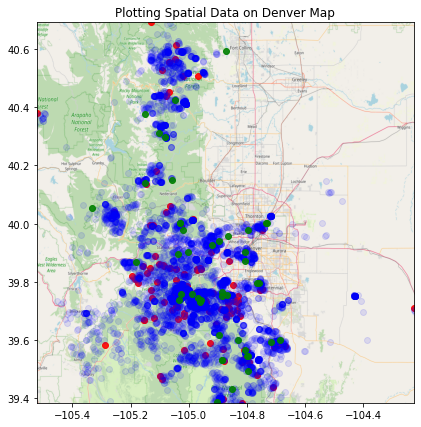

In [ ]:
denver = plt.imread('denver_map.png')
X_sub1 = df_2019Q2[tr['submarket'][1000] == 1]
X_sub2 = df_2019Q2[tr['submarket'][1000] == 2]
X_sub3 = df_2019Q2[tr['submarket'][1000] == 3]
BBox = (X_sub1.longitude.min(), X_sub1.longitude.max(),      
         X_sub1.latitude.min(), X_sub1.latitude.max())
        
fig, ax = plt.subplots(figsize = (8,7))

my_cmap = plt.cm.YlOrBr
my_cmap.set_under('w',1)

ax.scatter(X_sub1.longitude, X_sub1.latitude, color='r', alpha= 0.9, cmap=my_cmap)
ax.scatter(X_sub2.longitude, X_sub2.latitude, color='b', alpha= 0.1, cmap=my_cmap)
ax.scatter(X_sub3.longitude, X_sub3.latitude, color='g', alpha= 0.9, cmap=my_cmap)
ax.set_title('Plotting Spatial Data on Denver Map')
ax.set_xlim(BBox[0],BBox[1])
ax.set_ylim(BBox[2],BBox[3])
ax.imshow(denver, zorder=0, extent = BBox, aspect= 'equal')

plt.show()

In [ ]:
def submarket_pymc3(trace_category):
    
    values = np.unique(trace_category)

    for i in range(len(values)):

        X_sub = X[trace_category == values[i]]
        Y_sub = Y[trace_category == values[i]]
        
        # Ensure that sub-market has both classifications
        labels = np.unique(Y_sub)
        if len(labels) == 1:
            continue
            
        X_train, X_test, y_train, y_test = train_test_split(X_sub, Y_sub, test_size=0.3)

        model_sub = LogisticRegression().fit(X_train, y_train[:,1])

        train_acc = model_sub.score(X_train, y_train[:,1])
        test_acc = model_sub.score(X_test, y_test[:,1])
        auc = roc_auc_score(y_test[:,1], model_sub.predict(X_test)) 

        print("Sub-Market #{} Demand Prediction".format(i+1))
        print("Training Accuracy: {}%".format(train_acc*100))
        print("Testing Accuracy: {}%".format(test_acc*100))
        print("AUC: {} \n".format(auc))

In [ ]:
submarket_pymc3(tr['submarket'][1000])

Sub-Market #1 Demand Prediction
Training Accuracy: 69.76744186046511%
Testing Accuracy: 43.24324324324324%
AUC: 0.40384615384615385 

Sub-Market #2 Demand Prediction
Training Accuracy: 72.55697180378525%
Testing Accuracy: 72.07207207207207%
AUC: 0.5375701547798986 

Sub-Market #3 Demand Prediction
Training Accuracy: 62.5%
Testing Accuracy: 85.71428571428571%
AUC: 0.787878787878788 



In [ ]:
np.unique(tr['submarket'][3000], return_counts = True)

(array([0, 1, 3, 4]), array([6941,  124,    7,  495]))

In [ ]:
submarket_pymc3(tr['submarket'][-1000])

Sub-Market #1 Demand Prediction
Training Accuracy: 71.70028818443804%
Testing Accuracy: 70.85253456221197%
AUC: 0.5315537212088937 

Sub-Market #2 Demand Prediction
Training Accuracy: 68.81720430107528%
Testing Accuracy: 45.16129032258064%
AUC: 0.4666666666666667 



ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1c850c61-d934-4c85-b16d-3cb283df0c84' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>